In [ ]:
#This is sentiment analysis program that parses the tweets fetched from twitter using python
# Standard libraries
import re
import csv
import nltk
import spacy
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
style.use('seaborn-poster')
from PIL import Image
from wordcloud import WordCloud

# Downloads
nlp = spacy.load('en')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Preprocessing
import en_core_web_sm
from collections import Counter
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet  
from sklearn.feature_extraction.text import CountVectorizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Building classification models
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score,accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# import dataset 
train = pd.read_csv('/content/twitter_sentiment_data.csv')

In [ ]:
train = train.head(8000)
train['polarity'] = train['sentiment']
print(train.shape)

display(train.head())

percent_duplicates = round((1-(train['message'].nunique()/len(train['message'])))*100,2)
print('Duplicated tweets in train data:')
print(percent_duplicates,'%')

(8000, 4)


,sentiment,message,tweetid,polarity
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,-1
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641,1
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,1
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904,1
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153,2


Duplicated tweets in train data:
36.06 %


In [ ]:
def update_dataset(df):
  df = train.copy()
  sentiment = df['sentiment']
  word_sentiment = []

  for i in sentiment :
      if i == 1 :
          word_sentiment.append('Pro')
      elif i == 0 :
          word_sentiment.append('Neutral')
      elif i == -1 :
          word_sentiment.append('Anti')
      else :
          word_sentiment.append('News')

  df['sentiment'] = word_sentiment
    
  return df


df = update_dataset(train)
df.head()

,sentiment,message,tweetid,polarity
0,Anti,@tiniebeany climate change is an interesting h...,792927353886371840,-1
1,Pro,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641,1
2,Pro,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,1
3,Pro,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904,1
4,News,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153,2


In [ ]:
def hashtag_extract(tweet):
  hashtags = []
    
  for i in tweet:
      ht = re.findall(r"#(\w+)", i)
      hashtags.append(ht)
        
  hashtags = sum(hashtags, [])
  frequency = nltk.FreqDist(hashtags)
    
  hashtag_df = pd.DataFrame({'hashtag': list(frequency.keys()),
                       'count': list(frequency.values())})
  hashtag_df = hashtag_df.nlargest(15, columns="count")

  return hashtag_df

# Extracting the hashtags from tweets in each class
pro = hashtag_extract(df['message'][df['sentiment'] == 'Pro'])
anti = hashtag_extract(df['message'][df['sentiment'] == 'Anti'])
neutral = hashtag_extract(df['message'][df['sentiment'] == 'Neutral'])
news = hashtag_extract(df['message'][df['sentiment'] == 'News'])

pro.head()

,hashtag,count
0,BeforeTheFlood,228
176,ImVotingBecause,93
21,COP22,81
30,Ã,59
2,climate,53


In [ ]:
def TweetCleaner(tweet):
  tweet = tweet.lower() # Convert everything to lowercase
     
  tweet = re.sub('@[\w]*','',tweet) # Remove mentions  
    
  tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet) # Remove url's
    
  tweet = re.sub(r'#\w*', '', tweet) # Remove hashtags   
    
  tweet = re.sub(r'\d+', '', tweet) # Remove numbers 
    
  tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", ' ', tweet) # Remove punctuation
    
  tweet = re.sub(r"U+FFFD ", ' ', tweet) # Remove that funny diamond
    
  tweet = re.sub(r'\s\s+', ' ', tweet) # Remove extra whitespace

  tweet = tweet.lstrip(' ') # Remove space in front of tweet                      
    
  return tweet

# Clean the tweets in the message column
df['message'] = df['message'].apply(TweetCleaner)
df['message'] = df['message'].apply(TweetCleaner)

df.head()

,sentiment,message,tweetid,polarity
0,Anti,climate change is an interesting hustle as it ...,792927353886371840,-1
1,Pro,rt watch right here as travels the world to ta...,793124211518832641,1
2,Pro,fabulous leonardo s film on change is brillian...,793124402388832256,1
3,Pro,rt just watched this amazing documentary by le...,793124635873275904,1
4,News,rt pranita biswasi a lutheran from odisha give...,793125156185137153,2


In [ ]:
def lemma(df):
  df['length'] = df['message'].str.len()
  df['tokenized'] = df['message'].apply(word_tokenize)
  df['pos_tags'] = df['tokenized'].apply(nltk.tag.pos_tag)

  def get_wordnet_pos(tag):

      if tag.startswith('J'):
          return wordnet.ADJ

      elif tag.startswith('V'):
          return wordnet.VERB

      elif tag.startswith('N'):
          return wordnet.NOUN

      elif tag.startswith('R'):
          return wordnet.ADV
    
      else:
          return wordnet.NOUN

  wnl = WordNetLemmatizer()
  df['pos_tags'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
  df['lemmatized'] = df['pos_tags'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
  df['lemmatized'] = [' '.join(map(str, l)) for l in df['lemmatized']]  
  return df

df = lemma(df)
df.head()


,sentiment,message,tweetid,polarity,length,tokenized,pos_tags,lemmatized
0,Anti,climate change is an interesting hustle as it ...,792927353886371840,-1,122,"[climate, change, is, an, interesting, hustle,...","[(climate, n), (change, n), (is, v), (an, n), ...",climate change be an interesting hustle a it b...
1,Pro,rt watch right here as travels the world to ta...,793124211518832641,1,76,"[rt, watch, right, here, as, travels, the, wor...","[(rt, n), (watch, n), (right, r), (here, r), (...",rt watch right here a travel the world to tack...
2,Pro,fabulous leonardo s film on change is brillian...,793124402388832256,1,61,"[fabulous, leonardo, s, film, on, change, is, ...","[(fabulous, a), (leonardo, n), (s, n), (film, ...",fabulous leonardo s film on change be brillian...
3,Pro,rt just watched this amazing documentary by le...,793124635873275904,1,104,"[rt, just, watched, this, amazing, documentary...","[(rt, n), (just, r), (watched, v), (this, n), ...",rt just watch this amazing documentary by leon...
4,News,rt pranita biswasi a lutheran from odisha give...,793125156185137153,2,125,"[rt, pranita, biswasi, a, lutheran, from, odis...","[(rt, n), (pranita, n), (biswasi, v), (a, n), ...",rt pranita biswasi a lutheran from odisha give...


In [ ]:
def frequency(tweet):
  # Count vectorizer excluding english stopwords
  cv = CountVectorizer(stop_words='english')
  words = cv.fit_transform(tweet)
    
  # Count the words in the tweets and determine the frequency of each word
  sum_words = words.sum(axis=0)
  words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
  words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
  # Create a dataframe to store the top 25 words and their frequencies
  frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
  frequency = frequency.head(25)
    
  return frequency

# Extract the top 25 words in each class
pro_frequency = frequency(df['lemmatized'][df['sentiment']=='Pro'])
anti_frequency = frequency(df['lemmatized'][df['sentiment']=='Anti'])
news_frequency = frequency(df['lemmatized'][df['sentiment']=='News'])
neutral_frequency = frequency(df['lemmatized'][df['sentiment']=='Neutral'])

In [ ]:
# Extract the words in the tweets for the pro and anti climate change classes 
anti_words = ' '.join([text for text in anti_frequency['word']])
pro_words = ' '.join([text for text in pro_frequency['word']])
news_words = ' '.join([text for text in news_frequency['word']])
neutral_words = ' '.join([text for text in neutral_frequency['word']])

# Create wordcloud for the anti climate change class
anti_wordcloud = WordCloud(width=800, 
                           height=500, 
                           random_state=110, 
                           max_font_size=110, 
                           background_color='white',
                           colormap="Reds").generate(anti_words)
                          
# Create wordcolud for the pro climate change class
pro_wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=73, 
                          max_font_size=110, 
                          background_color='white',
                          colormap="Greens").generate(pro_words)

# Create wordcolud for the news climate change class
news_wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=0, 
                          max_font_size=110, 
                          background_color='white',
                          colormap="Blues").generate(news_words)

# Create wordcolud for the neutral climate change class
neutral_wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=10, 
                          max_font_size=110, 
                          background_color='white',
                          colormap="Oranges").generate(neutral_words)

pro_frequency.tail()

,word,freq
20,hoax,255
21,watch,239
22,million,236
23,don,228
24,make,224


In [ ]:
  def entity_extractor(tweet):
    def get_people(tweet):  
        words = nlp(tweet)
        people = [w.text for w in words.ents if w.label_== 'PERSON']
        return people
      
    def get_org(tweet):
        words = nlp(tweet)
        org = [w.text for w in words.ents if w.label_== 'ORG']
        return org
      
    def get_gpe(tweet):
        words = nlp(tweet)
        gpe = [w.text for w in words.ents if w.label_== 'GPE']
        return gpe
      
    # Extract the top 10 people
    people = tweet.apply(lambda x: get_people(x)) 
    people = [x for sub in people for x in sub]
    people_counter = Counter(people)
    people_count = people_counter.most_common(10)
    people, people_count = map(list, zip(*people_count))

    # Extract the top 10 organizations
    org = tweet.apply(lambda x: get_org(x)) 
    org = [x for sub in org for x in sub]
    org_counter = Counter(org)
    org_count = org_counter.most_common(10)
    org, org_count = map(list, zip(*org_count))
      
    # Extract the top 10 geopolitical entities
    gpe = tweet.apply(lambda x: get_gpe(x)) 
    gpe = [x for sub in gpe for x in sub]
    gpe_counter = Counter(gpe)
    gpe_count = gpe_counter.most_common(10)
    gpe, gpe_count = map(list, zip(*gpe_count))
      
    # Create a dataframe to store the information
    df = pd.DataFrame({'people' : people})
    df['geopolitics'] = gpe
    df['organizations'] = org
      
    return df

  # Extract top entities for each class
  anti_info = entity_extractor(df['lemmatized'][df['sentiment']=='Anti'])
  pro_info = entity_extractor(df['lemmatized'][df['sentiment']=='Pro'])
  news_info = entity_extractor(df['lemmatized'][df['sentiment']=='News'])
  neutral_info = entity_extractor(df['lemmatized'][df['sentiment']=='Neutral'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


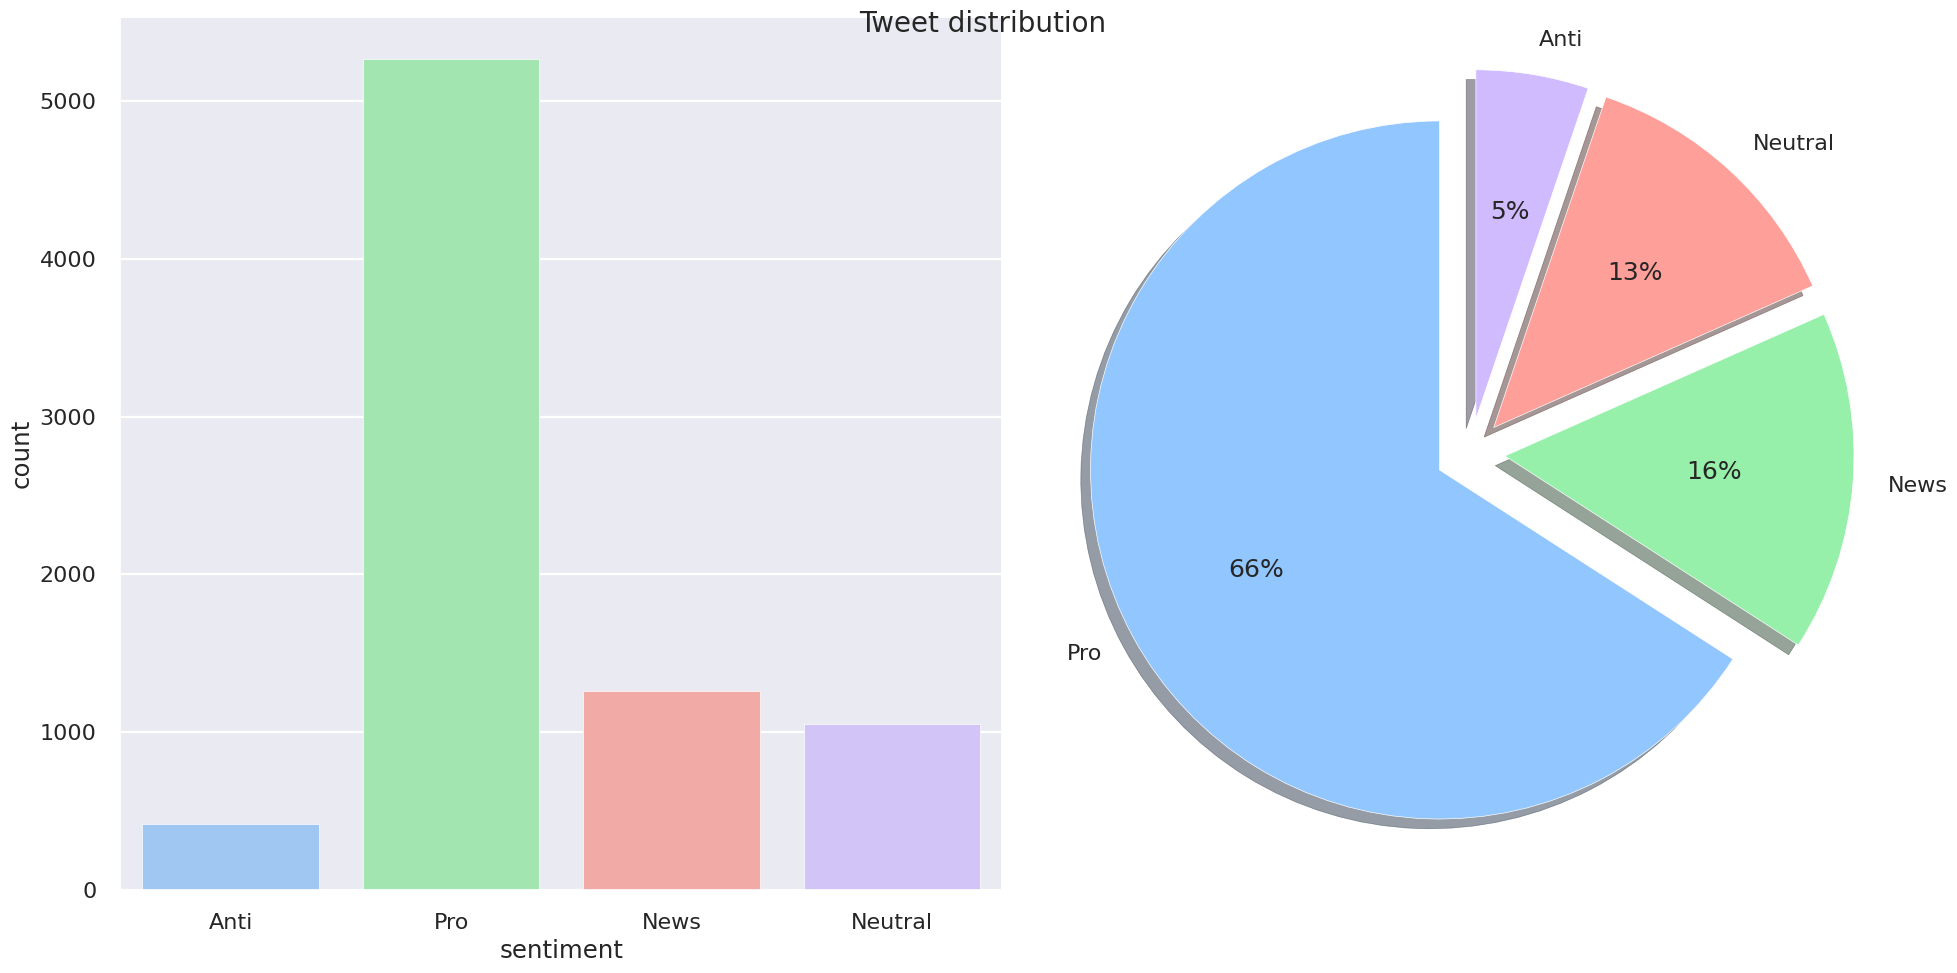

In [ ]:
style.use('seaborn-pastel')

fig, axes = plt.subplots(ncols=2, 
                         nrows=1, 
                         figsize=(20, 10), 
                         dpi=100)

sns.countplot(df['sentiment'], ax=axes[0])

labels=['Pro', 'News', 'Neutral', 'Anti'] 

axes[1].pie(df['sentiment'].value_counts(),
            labels=labels,
            autopct='%1.0f%%',
            shadow=True,
            startangle=90,
            explode = (0.1, 0.1, 0.1, 0.1))

fig.suptitle('Tweet distribution', fontsize=20)
plt.show()

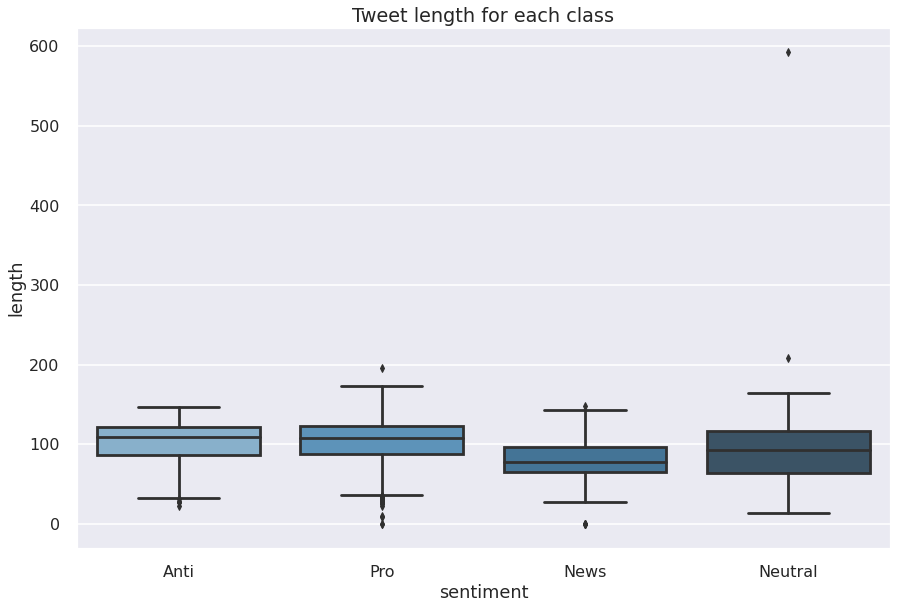

In [ ]:
# Plot the distribution of the length tweets for each class using a box plot
sns.boxplot(x=df['sentiment'], y=df['length'], data=df, palette=("Blues_d"))
plt.title('Tweet length for each class')
plt.show()

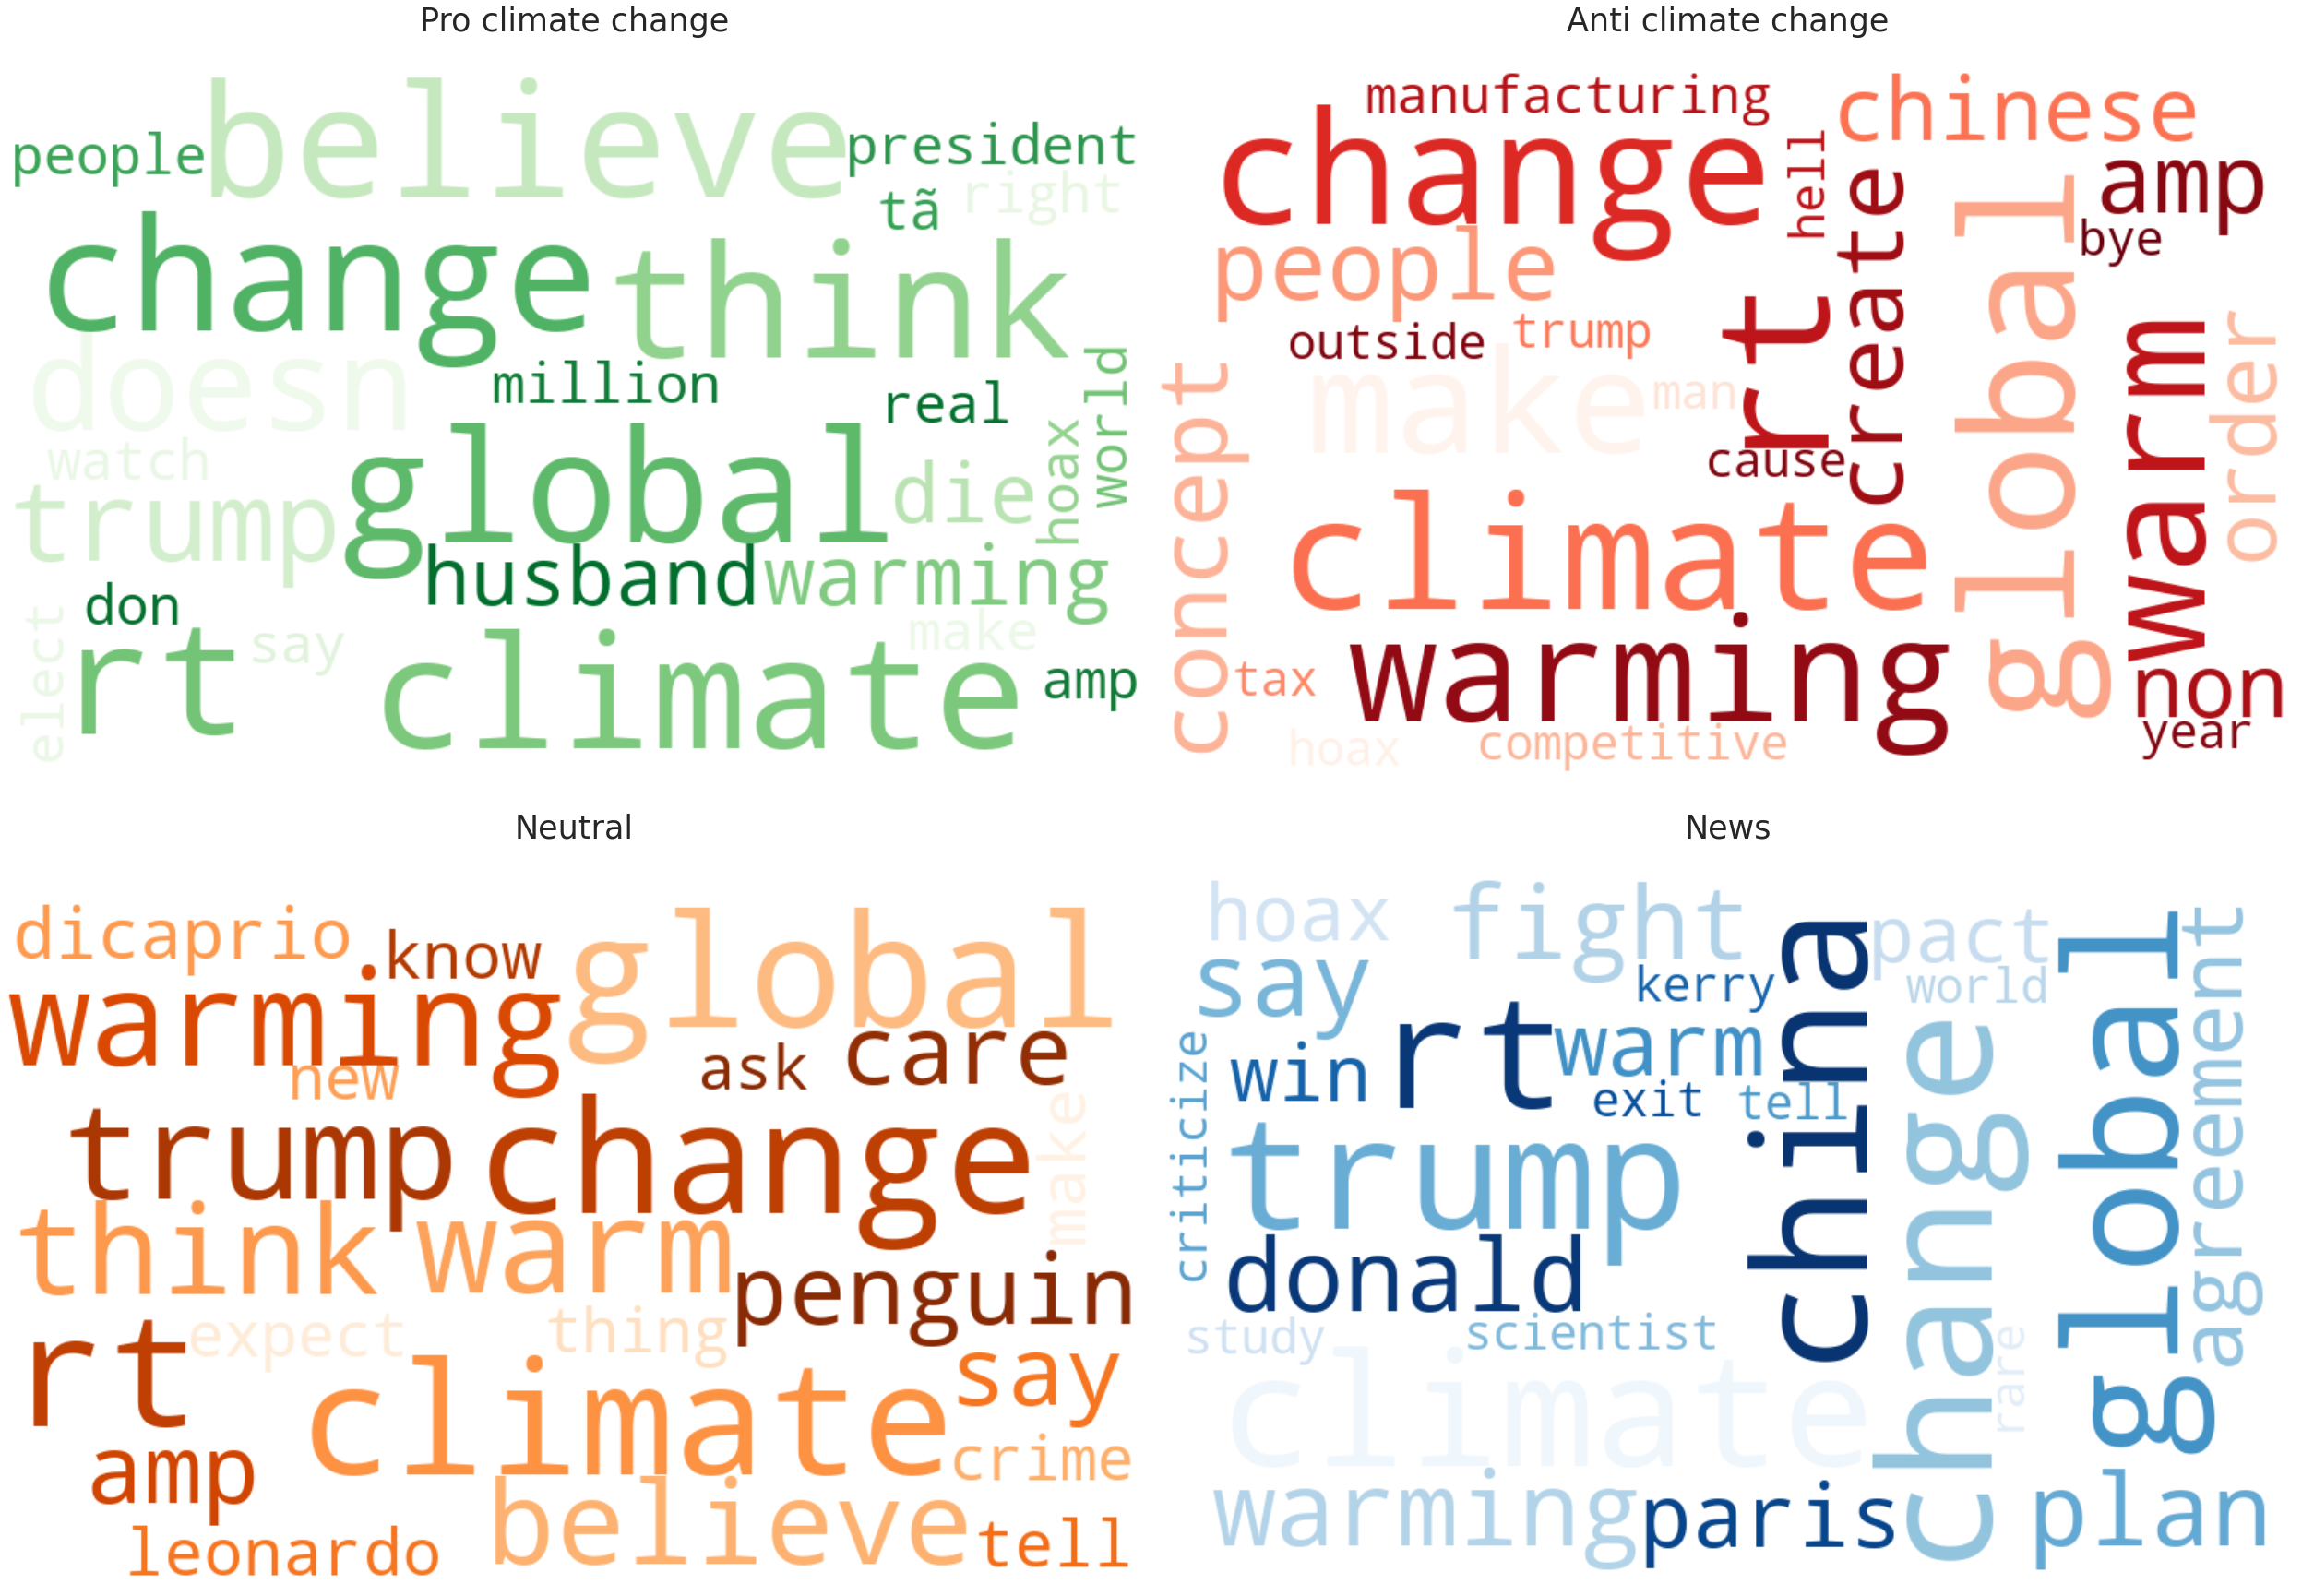

Pro climate change buzzwords 20-25 shown here for clarity 
- The wordcloud doesn't seem to pick up on 'http'


,word,freq
20,hoax,255
21,watch,239
22,million,236
23,don,228
24,make,224


In [ ]:
# Plot pro and anti wordclouds next to one another for comparisson
f, axarr = plt.subplots(2,2, figsize=(35,25))
axarr[0,0].imshow(pro_wordcloud, interpolation="bilinear")
axarr[0,1].imshow(anti_wordcloud, interpolation="bilinear")
axarr[1,0].imshow(neutral_wordcloud, interpolation="bilinear")
axarr[1,1].imshow(news_wordcloud, interpolation="bilinear")

# Remove the ticks on the x and y axes
for ax in f.axes:
    plt.sca(ax)
    plt.axis('off')

axarr[0,0].set_title('Pro climate change\n', fontsize=35)
axarr[0,1].set_title('Anti climate change\n', fontsize=35)
axarr[1,0].set_title('Neutral\n', fontsize=35)
axarr[1,1].set_title('News\n', fontsize=35)
#plt.tight_layout()
plt.show()

print("Pro climate change buzzwords 20-25 shown here for clarity \n- The wordcloud doesn't seem to pick up on 'http'")
display(pro_frequency.tail())

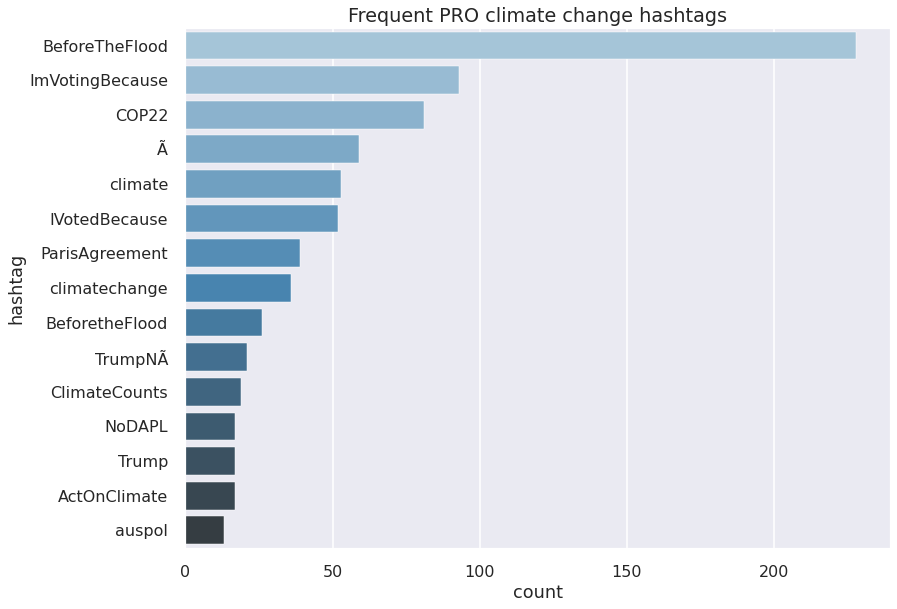

In [ ]:
# Plot the frequent hastags for pro and anti climate change classes
sns.barplot(data=pro,y=pro['hashtag'], x=pro['count'], palette=("Blues_d"))
plt.title('Frequent PRO climate change hashtags')
plt.tight_layout()


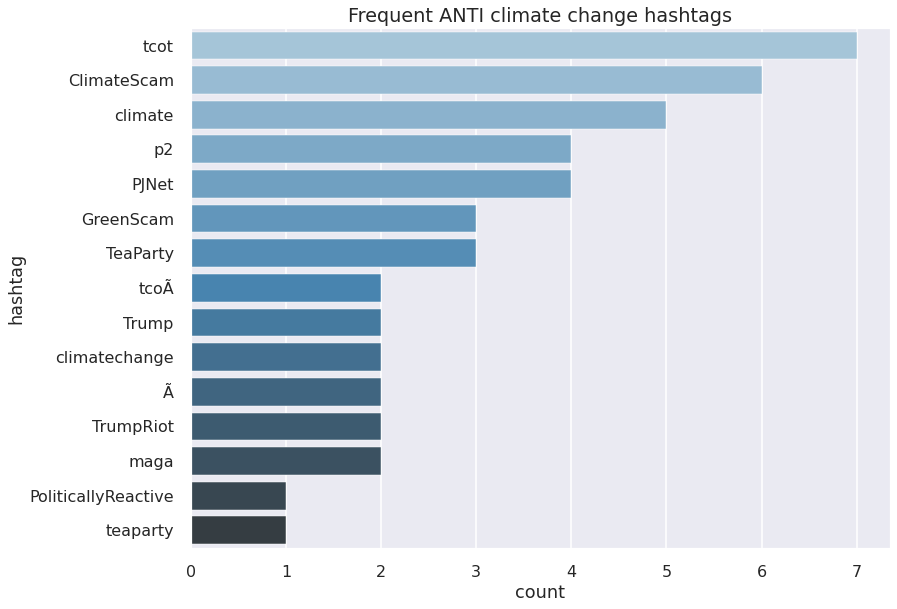

In [ ]:
sns.barplot(data=anti,y=anti['hashtag'], x=anti['count'], palette=("Blues_d"))
plt.title('Frequent ANTI climate change hashtags')
plt.tight_layout()

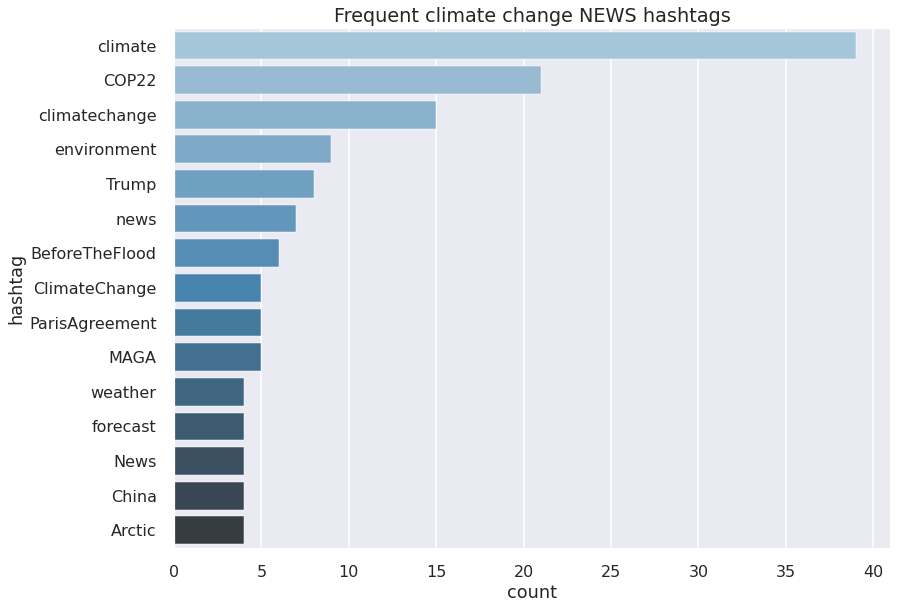

In [ ]:
# Plot the frequent hastags for the news and neutral classes
sns.barplot(y=news['hashtag'], x=news['count'], palette=("Blues_d"))
plt.title('Frequent climate change NEWS hashtags')
plt.tight_layout()

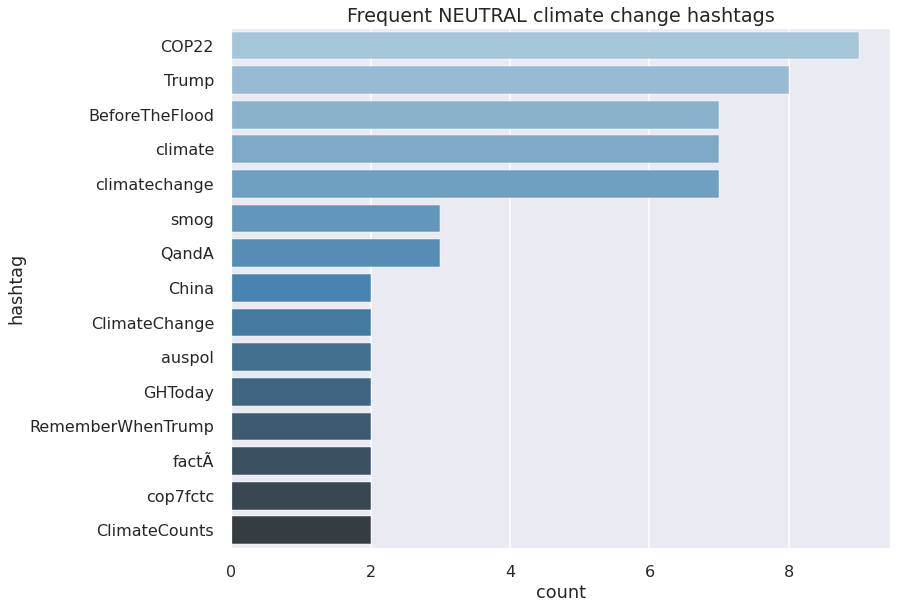

In [ ]:
sns.barplot(y=neutral['hashtag'], x=neutral['count'], palette=("Blues_d"))
plt.title('Frequent NEUTRAL climate change hashtags')
plt.tight_layout()

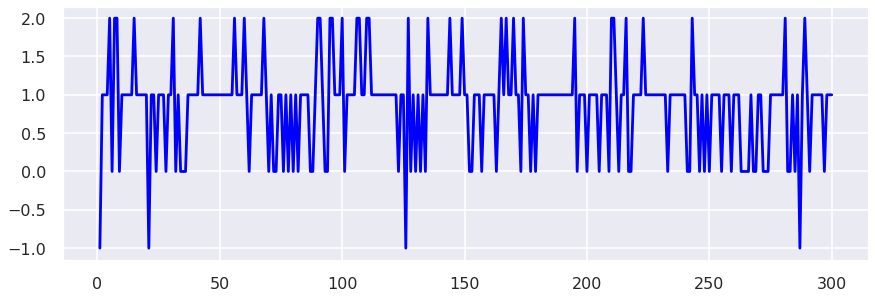

In [ ]:
list1 = range(1, 301)
list2 = train['polarity'][:300]
plt.rcParams["figure.figsize"] = [12.50, 4.50] 
plt.plot(list1, list2, c ="blue")
  
# To show the plot
plt.show()

In [ ]:
print('Pro climate change information')
display(pro_info.head(9))

In [ ]:
print('Anti climate change information')
display(anti_info)

In [ ]:
# Model Building
X = df['message']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Random Forest Classifier
rf = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', RandomForestClassifier(max_depth=5, 
                                              n_estimators=100))])

# Naïve Bayes:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB())])

# Linear SVC:
lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', LinearSVC(class_weight='balanced'))])

# Decision Tree
dtree = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', DecisionTreeClassifier(criterion = 'entropy'))])

In [ ]:
# Random forest 
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Niave bayes
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# Linear SVC
lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_test)

# Decision Tree
dtree.fit(X_train, y_train)
y_pred_dtree = dtree.predict(X_test)

In [ ]:
rf_accu = accuracy_score(y_pred_rf,y_test)
rf_prec = precision_score(y_pred_rf,y_test,average = 'weighted')
nb_accu = accuracy_score(y_pred_nb,y_test)
nb_prec = precision_score(y_pred_nb,y_test,average = 'weighted')
lsvc_accu = accuracy_score(y_pred_lsvc,y_test)
lsvc_prec = precision_score(y_pred_lsvc,y_test,average = 'weighted')
dtree_accu = accuracy_score(y_pred_dtree,y_test)
dtree_prec = precision_score(y_pred_dtree,y_test,average = 'weighted')

In [ ]:
models = {
    'DecisionTreeClassifier(entropy)':[dtree_accu,y_pred_dtree],
    'Linear SVC':[lsvc_accu,y_pred_lsvc],
    'RandomForestClassifier':[rf_accu,y_pred_rf],
    'MultinomialNB': [nb_accu,y_pred_nb]
}

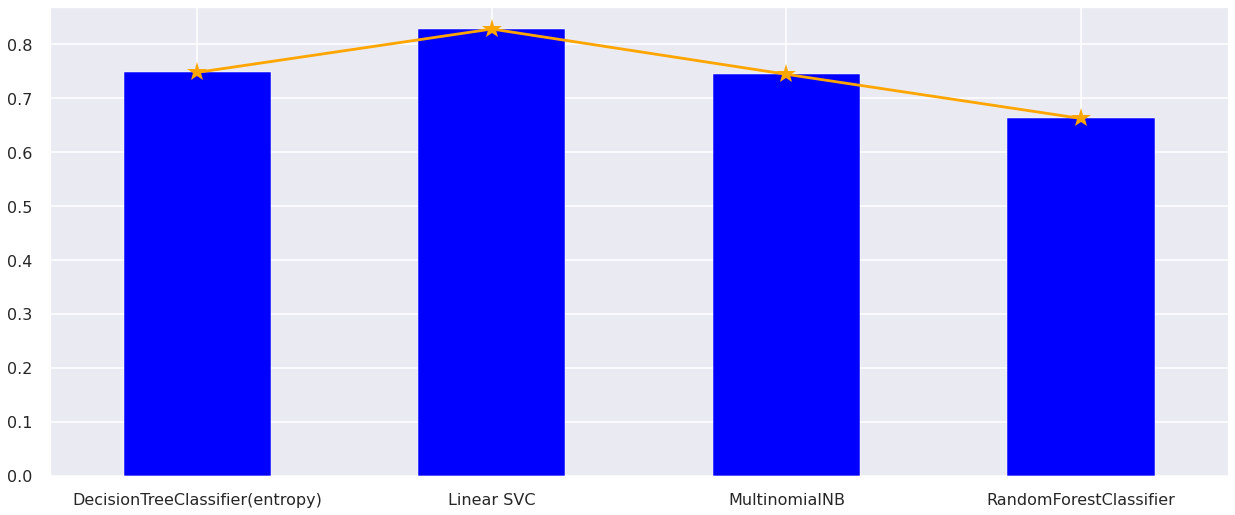

In [ ]:
models_accu = {
    'DecisionTreeClassifier(entropy)': dtree_accu,
    'Linear SVC': lsvc_accu,
    'RandomForestClassifier': rf_accu,
    'MultinomialNB': nb_accu
}

plt.rcParams["figure.figsize"] = [17.50, 7.50]
plt.rcParams["figure.autolayout"] = True

df = pd.DataFrame(dict(data=models_accu))
fig, ax = plt.subplots()

df['data'].plot(kind='bar', color='blue')
df['data'].plot(kind='line', marker='*', color='orange', ms=20)

plt.show()

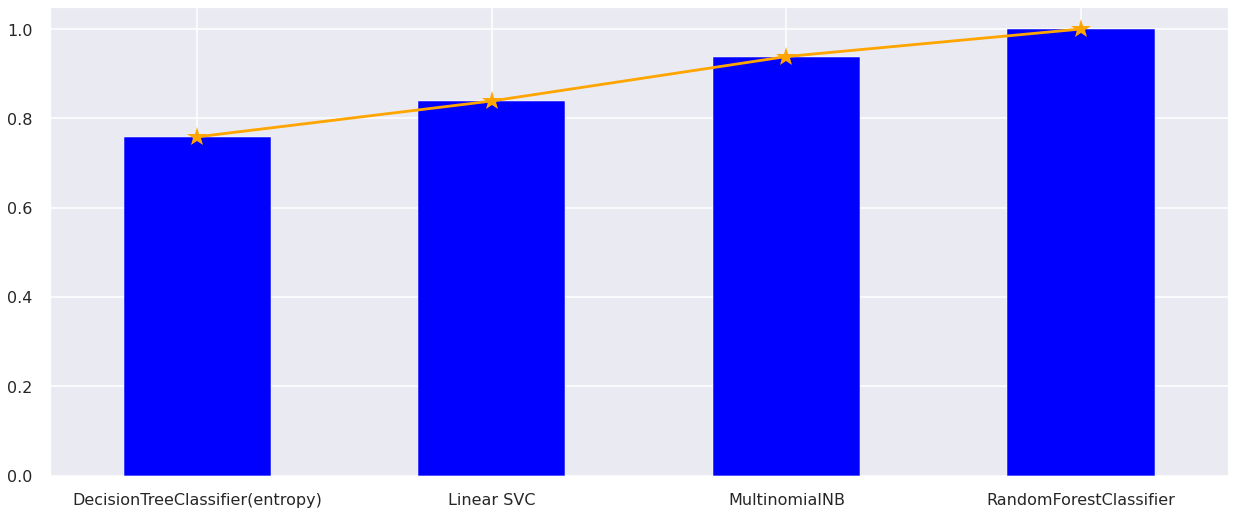

In [ ]:
models_prec = {
    'DecisionTreeClassifier(entropy)': dtree_prec,
    'Linear SVC': lsvc_prec,
    'RandomForestClassifier': rf_prec,
    'MultinomialNB': nb_prec
}

plt.rcParams["figure.figsize"] = [17.50, 7.50]
plt.rcParams["figure.autolayout"] = True

df = pd.DataFrame(dict(data=models_prec))
fig, ax = plt.subplots()

df['data'].plot(kind='bar', color='blue')
df['data'].plot(kind='line', marker='*', color='orange', ms=20)

plt.show()

In [ ]:
max_accu = max(models_accu, key=models_accu.get)
print("Max accuracy is : {}".format(max_accu))
print(models_accu[max_accu]*100)

Max accuracy is : Linear SVC
82.85


In [ ]:
max_prec = max(models_prec, key=models_prec.get)
print("Max precision is : {}".format(max_prec))
print(models_prec[max_prec]*100)

Max precision is : RandomForestClassifier
100.0


In [ ]:
# Confusion Matrix
cm_lsvc = confusion_matrix(y_pred_lsvc,y_test);
cm_lsvc

array([[  46,    5,    1,   18],
       [  11,  173,   10,   55],
       [   1,   19,  241,   55],
       [  33,   97,   38, 1197]])

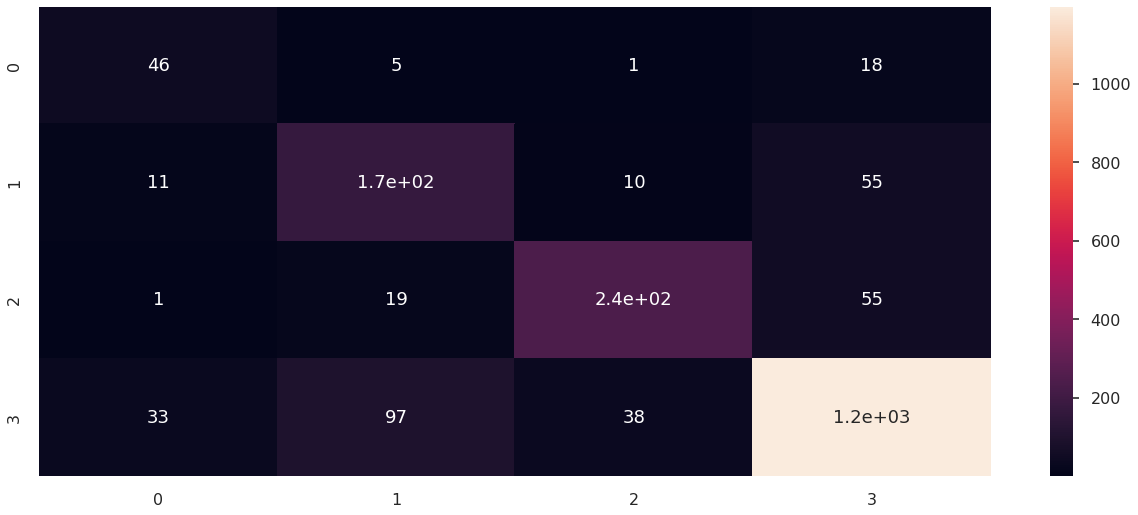

In [ ]:
sns.heatmap(cm_lsvc,annot = True)

In [ ]:
# Classification Report 

lsvc_clr = classification_report(y_pred_rf,y_test)
lsvc_clr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n        Anti       0.00      0.00      0.00         0\n     Neutral       0.00      0.00      0.00         0\n        News       0.00      0.00      0.00         0\n         Pro       1.00      0.66      0.80      2000\n\n    accuracy                           0.66      2000\n   macro avg       0.25      0.17      0.20      2000\nweighted avg       1.00      0.66      0.80      2000\n'

In [ ]:
rf_clr = classification_report(y_pred_rf,y_test)
rf_clr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n        Anti       0.00      0.00      0.00         0\n     Neutral       0.00      0.00      0.00         0\n        News       0.00      0.00      0.00         0\n         Pro       1.00      0.66      0.80      2000\n\n    accuracy                           0.66      2000\n   macro avg       0.25      0.17      0.20      2000\nweighted avg       1.00      0.66      0.80      2000\n'